In [1]:
import re, pprint, os, numpy,string
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics.cluster import *
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from deep_translator import GoogleTranslator
from langdetect import detect
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\i100v\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def read_files(path):
    print("Reading files...")
    listing = os.listdir(folder)
    texts=[]
    for file in listing:
        if file.endswith(".txt"):
            url = folder+"/"+file
            f = open(url,encoding="latin-1");
            raw = f.read()
            f.close()
            texts.append(raw)
    return texts

def  first_rude_clean_text(texts):
    for txt in range(len(texts)):
        texts[txt] = texts[txt].lower()
        texts[txt]=re.sub('<.*?>', '', texts[txt])
        texts[txt] = re.sub("\n","",texts[txt])
        texts[txt] = re.sub(r"(@[A-Za-z]+)|([^A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", texts[txt]) 
        
    return texts
        
def translate_texts(texts):
    print("Translating...")
    for txt in range(len(texts)):
        if detect(texts[txt])=='es':
            if(len(texts[txt])>4000):
                chunks, chunk_size = len(texts[txt])//4000, 4000
                chunks_txt= [ texts[txt][i:i+chunk_size] for i in range(0, chunks, chunk_size) ]
                for j in range(len(chunks_txt)):
                    chunks_txt[j] = GoogleTranslator(source='es', target='en').translate(chunks_txt[j])
                texts[txt]=''.join(chunks_txt)
            else:
                texts[txt]=GoogleTranslator(source='es', target='en').translate(texts[txt])
    return texts
    
def tokenize_texts(texts):
    for txt in range(len(texts)):
        texts[txt]=word_tokenize(texts[txt])
    return texts  

def clean_stop_words_punct (texts):
    stop = stopwords.words('english')
    punct = list(string.punctuation)
    for txt_tok in range(len(texts)):
        texts[txt_tok] = [w for w in texts[txt_tok] if w not in (stop) and w not in (punct) ]
    return texts

def first_processing(texts):
    texts=first_rude_clean_text(texts)
    texts=translate_texts(texts)
    texts=tokenize_texts(texts)
    texts=clean_stop_words_punct(texts)
    return texts
       
def stemmer_text(texts):
    stemmer = SnowballStemmer("english")
    for txt_tok in range(len(texts)):
        texts[txt_tok] = [stemmer.stem(t) for t in texts[txt_tok]]
    return texts
        
def lemman_text(texts):
    for txt_tok in range(len(texts)):
        texts[txt_tok] = [WordNetLemmatizer().lemmatize(w) for w in texts[txt_tok]]
    return texts

def get_term_matrix(texts):
    total_w=set()
    for txt in texts:
        for w in txt:
            total_w.add(w)
    total_words=list(total_w)
    table=[]
    for text in texts:
        row=np.zeros(len(total_words))
        for word in text:
            index=total_words.index(word)
            row[index]+=1
        table.append(row)
    df=pd.DataFrame(table)
    df.columns=total_words
    return df

In [3]:
folder = "../data/"
texts=read_files(folder)
texts=first_processing(texts)

Reading files...
Translating...


<AxesSubplot:>

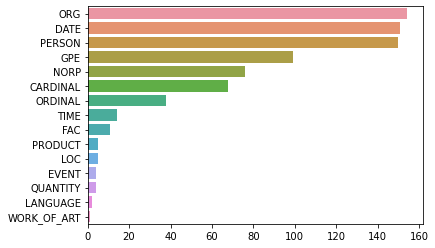

In [13]:
import spacy
nlp = spacy.load("en_core_web_sm")

def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

joined=[]
for i in texts:
    joined.append(' '.join(i))

df=pd.DataFrame(joined)
df.columns=['text']
ent=df['text'].apply(lambda x : ner(x))
ent=[x for sub in ent for x in sub]
counter=Counter(ent)
count=counter.most_common()
x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)


D:\AnacondaPython\envs\NLP\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\AnacondaPython\envs\NLP\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\AnacondaPython\envs\NLP\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\AnacondaPython\e

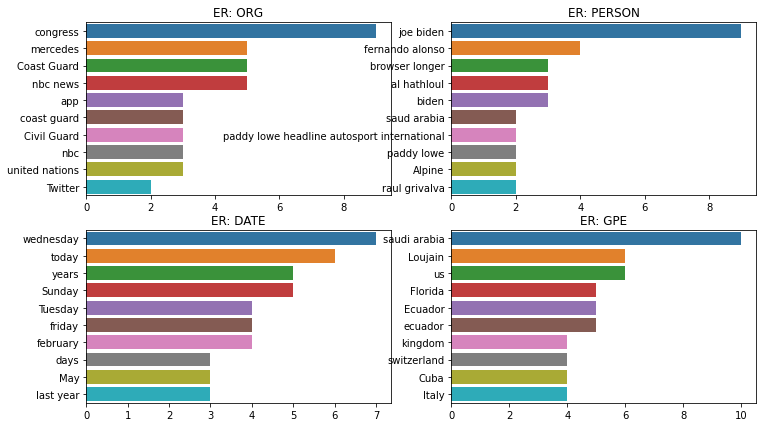

In [52]:
def ner(text,ent="ORG"):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]
j=0
fig, ax = plt.subplots (ncols=2,nrows=2,figsize=(12,7),constrained_layout=False)
i=0
for tipe in ['ORG','DATE','PERSON','GPE']:
    gpe=df['text'].apply(lambda x: ner(x,tipe))
    gpe=[i for x in gpe for i in x]
    counter=Counter(gpe)
    x,y=map(list,zip(*counter.most_common(10)))
    sns.barplot(y,x,ax=ax[j,i])
    ax[j,i].title.set_text('ER: '+tipe)
    j=j+1
    if j==2:
        i=1
        j=0
plt.show()

<AxesSubplot:>

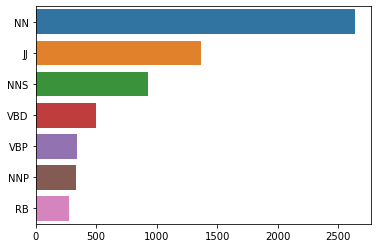

In [20]:
def pos(text):
    pos=nltk.pos_tag(word_tokenize(text))
    pos=list(map(list,zip(*pos)))[1]
    return pos
tags=df['text'].apply(lambda x : pos(x))
tags=[x for l in tags for x in l]
counter=Counter(tags)
x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

D:\AnacondaPython\envs\NLP\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\AnacondaPython\envs\NLP\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\AnacondaPython\envs\NLP\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\AnacondaPython\e

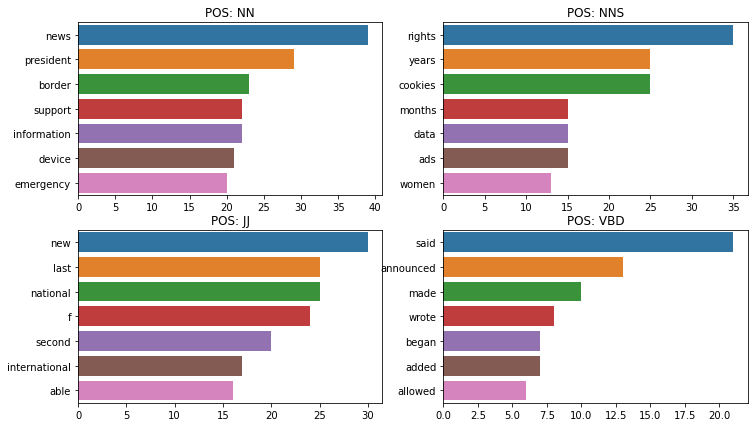

In [54]:
def get_adjs(text,tipe):
    adj=[]
    pos=nltk.pos_tag(word_tokenize(text))
    for word,tag in pos:
        if tag==tipe:
            adj.append(word)
    return adj

j=0
fig, ax = plt.subplots (ncols=2,nrows=2,figsize=(12,7),constrained_layout=False)
i=0
for tipe in ['NN','JJ','NNS','VBD']:
    words=df['text'].apply(lambda x : get_adjs(x,tipe))
    words=[x for l in words for x in l]
    counter=Counter(words)
    x,y=list(map(list,zip(*counter.most_common(7))))
    sns.barplot(y,x,ax=ax[j,i])
    ax[j,i].title.set_text('POS: '+tipe)
    j=j+1
    if j==2:
        i=1
        j=0
plt.show()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\i100v\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,text,pol
0,browser longer compatible visit country best e...,1
1,efe prominent saud activist defender human rig...,1
2,experience live buy tickets formula races auto...,1
3,browser longer compatible visit country best e...,1
4,Formula Formula Fernando Alonso hit vehicle Th...,1
5,news fernando alonso conscious well road cycli...,1
6,us president joe biden rescinded national emer...,1
7,browser longer compatible visit country best e...,1
8,Image source us coast guard district people ca...,1
9,last news see month subscribe months already s...,1


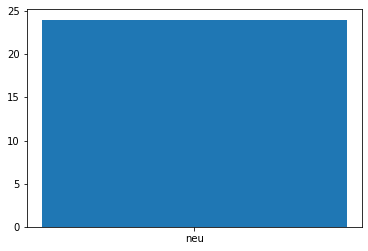

In [28]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

df['pol']=df['text'].map(lambda x: get_vader_score(x))
polarity=df['pol'].replace({0:'neg',1:'neu',2:'pos'})
plt.bar(polarity.value_counts().index,
        polarity.value_counts())
df

<AxesSubplot:>

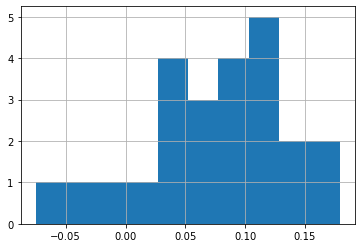

In [56]:
from textblob import TextBlob
def polarity(text):
    return TextBlob(text).sentiment.polarity
df['pol_scr']=df['text'].apply(lambda x : polarity(x))
df['pol_scr'].hist()

<BarContainer object of 2 artists>

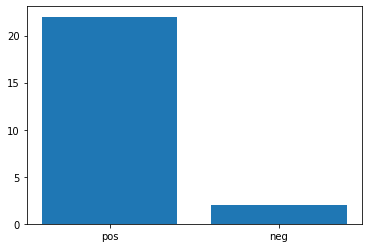

In [57]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'
    
df['pol']=df['pol_scr'].map(lambda x: sentiment(x))
plt.bar(df.pol.value_counts().index,
       df.pol.value_counts())